In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

%matplotlib inline
from IPython import display


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch


from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

/tmp/ipykernel_60331/254083166.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-03-08 09:18:26.650250: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-08 09:18:26.685832: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 09:18:

In [2]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so let's set default device to GPU
    torch.set_default_device(0)
    print("CUDA is available. Using GPU.")
else:
    # CUDA is not available, so let's use the CPU
    print("CUDA is not available. Using CPU.")

# Example usage:
tensor = torch.randn(3, 3)  # Create a tensor on the selected device
print("Tensor is on device:", tensor.device)

CUDA is available. Using GPU.
Tensor is on device: cuda:0


In [3]:
channel_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06','Cloud_B07',
                 'Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13']

data_water=parse.parse('cloudrm_water.dat')
data_clear=parse.parse('cloudrm_clear.dat')
data_ice=parse.parse('cloudrm_ice.dat')
data_mixed=parse.parse('cloudrm_mixed.dat')

#Concatinate all datasets
#data_all=pd.concat([data_water, data_clear, data_ice, data_mixed])
data_all=pd.concat([data_water,data_clear,data_ice,data_mixed])
#data_all=pd.concat([data_ice])
data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])
data_all=data_all.reset_index()
data_all=data_all.drop(columns=('index'))

df=data_all.copy()

##Train test validation split##
#X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
#           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13',
#           'Sat_Zenith_Angle','Sun_Zenith_Angle','Azimuth_Diff_Angle']

X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13']
#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.
y_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05',
              'Clear_B06','Clear_B07','Clear_B08', 'Clear_B09',
              'Clear_B10','Clear_B11','Clear_B12','Clear_B13']

In [4]:
df

,Cloud_B02,Cloud_B03,Cloud_B04,Cloud_B05,Cloud_B06,Cloud_B07,Cloud_B08,Cloud_B09,Cloud_B10,Cloud_B11,...,Clear_B12,Clear_B13,Sat_Zenith_Angle,Sun_Zenith_Angle,Azimuth_Diff_Angle,COT,Cloud_Type,Profile_ID,GOT,Water_Vapor
0,0.89822,0.82430,0.84322,0.75232,0.79863,0.86702,0.75245,0.91433,0.38607,0.03711,...,0.91403,0.38977,4.35,56.99,22.96,23.397,2,8973,0.129,6.37
1,0.29968,0.27558,0.37609,0.27122,0.48121,0.90663,0.86953,0.91666,0.40817,0.01788,...,0.94397,0.84026,12.27,60.32,81.41,2.452,2,3598,0.123,0.46
2,0.37579,0.39177,0.55448,0.47159,0.79124,0.93204,0.88240,0.94466,0.37695,0.01356,...,0.77680,0.58545,2.12,55.76,50.24,6.564,5,9625,0.122,0.69
3,0.73411,0.70360,0.76401,0.74330,0.80824,0.99764,0.89247,1.03605,0.41092,0.00615,...,0.93925,0.84693,1.46,44.21,106.95,29.710,3,6165,0.128,2.96
4,0.61763,0.60034,0.65471,0.70713,0.73157,0.75289,0.76990,0.79839,0.66608,0.18275,...,0.96311,0.95261,12.33,40.58,172.91,17.975,4,2862,0.105,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0.54497,0.50832,0.61099,0.77017,0.84129,0.85560,0.81355,0.86628,0.49961,0.07801,...,0.92982,0.87786,7.37,70.07,40.61,11.154,10,4023,0.123,0.85
199996,0.67646,0.64323,0.69696,0.67262,0.75384,1.01997,0.98172,1.02272,0.67529,0.25038,...,0.86929,0.68721,5.06,39.36,3.69,18.838,11,3253,0.110,0.28
199997,0.80252,0.76409,0.80857,0.79187,0.83445,0.96384,0.86138,1.00325,0.50672,0.07686,...,0.93421,0.66330,7.75,43.19,157.29,40.314,9,5982,0.128,4.28
199998,0.70670,0.66006,0.70197,0.65865,0.71489,0.89682,0.76990,0.93910,0.29262,0.01036,...,0.91767,0.77138,6.89,59.56,156.13,26.983,10,8629,0.128,5.19


In [5]:
X=df[X_labels]
y=df[y_labels]

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.1)

In [6]:
import random

val_size=0.1
validation_indices=np.array(random.sample(range(len(X_train['Cloud_B02'])), int(len(data_all['Cloud_B02'])*val_size)))
train_indices=[i for i in range(len(X_train['Cloud_B02'])) if np.any(validation_indices==i)==False]

---No improvement in 100 epochs, broke early---
Best model out of total max epochs found at epoch 506
Model all saved...


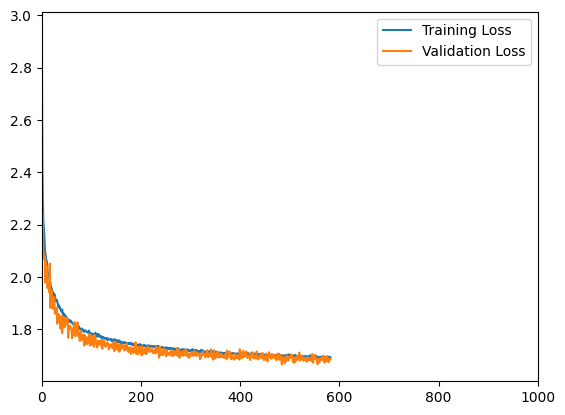

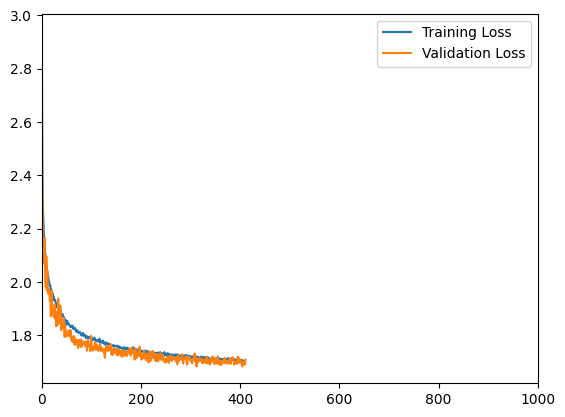

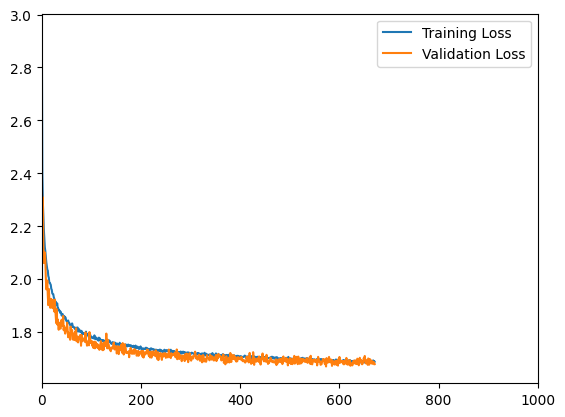

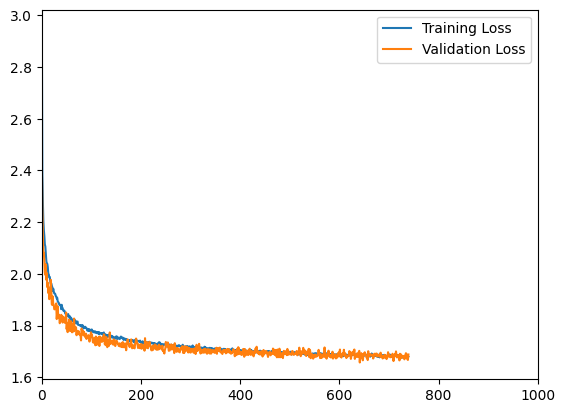

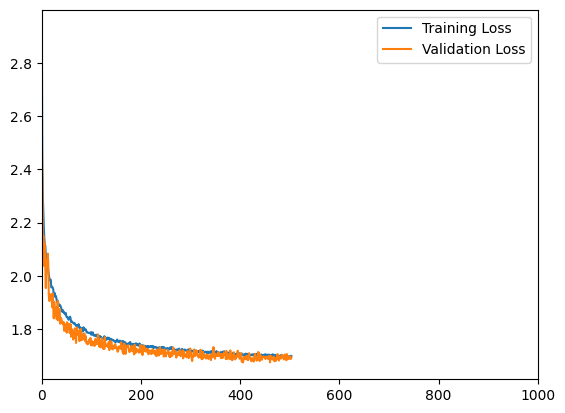

In [7]:
quantiles=np.array([0.1,0.5,0.9])
batch_size=500
save=True
ensamble=5

nepochs=1000
models=[QuantileNetwork(quantiles=quantiles) for i in range(ensamble)]

n_nodes_all=100
sequence_all=lambda: nn.Sequential(
    nn.Linear(len(X_labels),n_nodes_all),
    nn.ReLU(),
    nn.Linear(n_nodes_all,n_nodes_all),
    nn.BatchNorm1d(n_nodes_all),
    nn.ReLU(),
    nn.Linear(n_nodes_all,n_nodes_all),
    nn.BatchNorm1d(n_nodes_all),
    nn.ReLU(),
    nn.Linear(n_nodes_all,n_nodes_all),
    nn.BatchNorm1d(n_nodes_all),
    nn.ReLU(),
    nn.Linear(n_nodes_all,n_nodes_all),
    nn.BatchNorm1d(n_nodes_all),
    nn.ReLU(),
    nn.Linear(n_nodes_all,n_nodes_all),
    nn.BatchNorm1d(n_nodes_all),
    nn.ReLU(),
    nn.Linear(n_nodes_all, len(quantiles)*len(y_labels)) #Output dimesion is number of quantiles times number of target variables
)

for i,model in enumerate(models):
    main_filepath="pytorch_models/cont_test"
    model.fit(X_train.to_numpy(),y_train.to_numpy(), 
            train_indices, 
            validation_indices, 
            batch_size=batch_size,
            nepochs=nepochs,
            sequence=sequence_all(),
            lr=0.003,
            data_norm=True,
            verbose=False,
            plot_training=True,
            early_break=True)

    if save:
        filepath=main_filepath+'/model'+str(i)
        os.makedirs(filepath,exist_ok=True)
        torch.save(model,filepath+'/model_file')
        print("Model all saved...")
if save:
    X_test.to_csv(main_filepath+'/xtest.csv',index=True)
    y_test.to_csv(main_filepath+'/ytest.csv',index=True)


In [8]:


main_filepath='pytorch_models/cont_test'
n_ensemble=2
models=[]
for i in range(n_ensemble):
    models.append(torch.load(main_filepath+'/model'+str(i)+'/model_file'))

X_test=pd.read_csv(main_filepath+'/xtest.csv',index_col=0)
y_test=pd.read_csv(main_filepath+'/ytest.csv',index_col=0)
y_true=y_test.to_numpy()

In [9]:
X_test = X_test + np.random.randn(np.shape(X_test)[0],np.shape(X_test)[1]) * np.mean(X_test.to_numpy(),axis=0)*0.03

In [10]:
for i,model in enumerate(models):
    if i==0:
        pred_y=model.predict(X_test.to_numpy())
    else:   
        pred_y=pred_y+model.predict(X_test.to_numpy())
pred_y=pred_y/len(models)

In [11]:
from functions.plot_metrics import plot_metrics
from functions import calc_metrics

/home/edgelab/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/edgelab/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/edgelab/filip/SEEX30_Cloud_Fog/SEEX30_Cloud_Fog/Cloud_rm/functions/plot_metrics.py:207: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.errorbar(x=np.linspace(0,len(y_pred_sort_samp[i][:,1]),len(y_pred_sort_samp[i][:,1]))


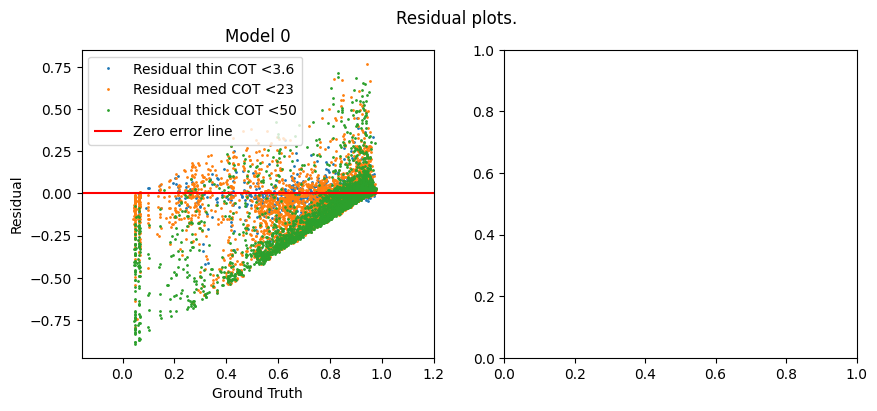

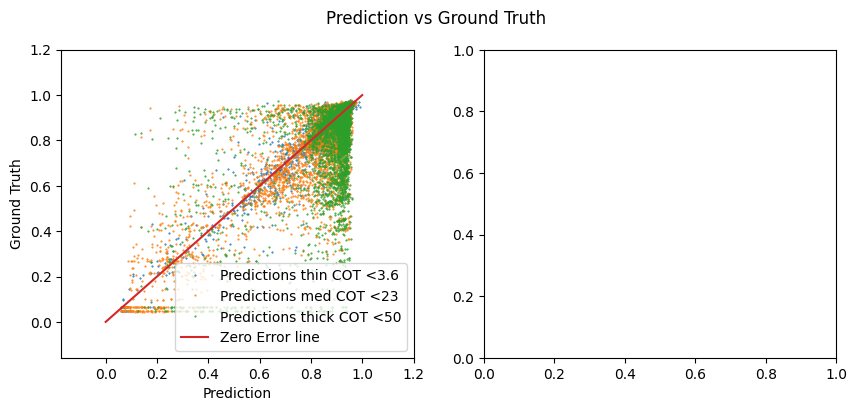

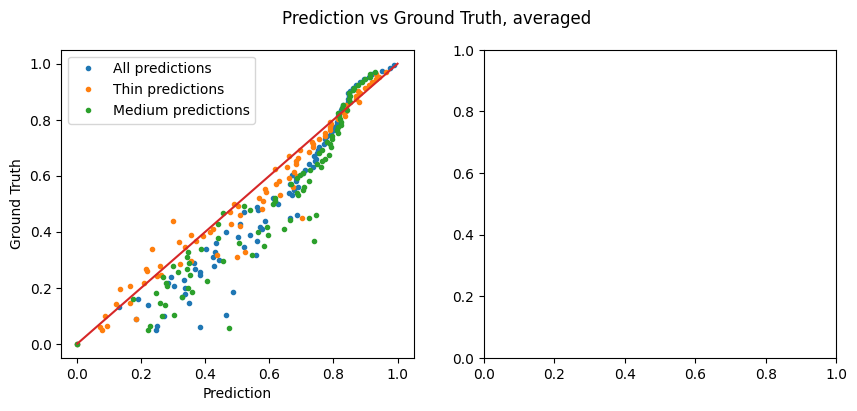

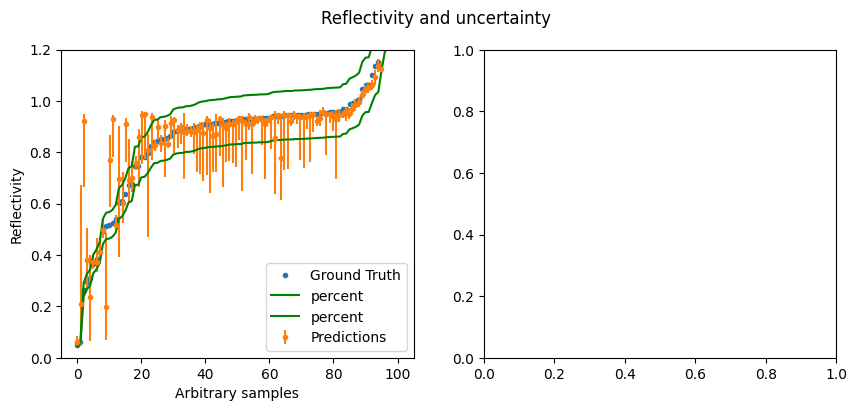

In [12]:
plt.rcParams["figure.figsize"] = [10, 4]
figs,axs,mses,r2s,psnrs,quantrates,quantcrosses = plot_metrics([models],
                                                                [X_test],
                                                                [y_test],
                                                                [pred_y],
                                                                df,
                                                                samples=100,
                                                                nrows=1,
                                                                ncols=2,
                                                                is_ensemble=True)

In [13]:
MSE=[]
R2=[]
PSNR=[]
quantrates=[]
quantcross=[]

MSE.append(mean_squared_error(y_true,pred_y[:,:,1]))
R2.append(r2_score(y_true,pred_y[:,:,1]))
PSNR.append(calc_metrics.PSNR(y_true,pred_y[:,:,1]))
quantrates.append(calc_metrics.quant_rate(y_true,pred_y))
quantcross.append(calc_metrics.quant_cross(pred_y))

In [14]:

print("MSE: "+str(MSE[0]))
print(" ")
print("R2 score: "+str(R2[0]))
print(" ")

print("PSNR: "+str(PSNR[0]))
print(" ")
print("Quantrate: "+str(quantrates[0]))
print(" ")
print("Quantile crossing: "+str(quantcross[0]))

MSE: 0.007249657374108453
 
R2 score: 0.9094020135143456
 
PSNR: 26.09635538779937
 
Quantrate: [0.08658333 0.49314583 0.9215375 ]
 
Quantile crossing: 0.0
